# Stroke Detection Project
## Machine Learning Labs Python
## by Jeremy Schwartzbord (Spring '22 SPOC cohort)

### Problem Statement
The purpose of this notebook is to train a machine learning model that predicts whether a patient has a stroke or not, using a data set of 5110 patients. Each patient represents an observation where we know if he or she had a stroke, as well as other demographic (i.e., gender, age, etc), lifestyle (i.e., smoking) and health history variables (i.e., hypertension, BMI, glucose, etc.)  Given these variables, how accurately can we predict if a patient has a stroke?  We will start with the aforementioned data set, and a secondary objective, at the end of this project, will be to conclude whether the data set provided is sufficient for accurate prediction of stroke, or if additional data, such as more patient data or additional health history variables, will be needed to improve our model. 

This project will be organized as follows:

i. Exploratory data analysis

ii. Feature engineering and selection

iii. Model training 

iv. Model evaluation

In [790]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Cleaning and Exploratory Data Analysis

In [791]:
#import data

df = pd.read_csv('stroke_data.csv',sep=",",index_col="id")

# we create a copy of the native data set without cleaning, in case we need it later
df_native = df.copy()

The data set includes 11 columns total, including our target- stroke occurrence. Taking a look at the first few rows of data and summary statistics (below), there are clearly columns of data that require cleanup and opportunities for feature engineering. For instance, within the first few observations, a value for bmi is missing. The summary statistics for BMI indicate  4 909 observations, not 5110, so BMI is missing for 201 study participants. Furthermore, some columns are numeric (columns age, hypertension, heart_disease, avg_glucose_level, bmi, and stroke), while others are not (gender, ever_married, work_type, Residence_type, smoking_status). All variables must be numeric when we train our model, so we will undertake feature engineering in order to transform the categorical variables to numeric ones in the next section. 

In [793]:
len(df)

5110

In [794]:
#target
df.columns[-1]

'stroke'

In [795]:
#variables
df.columns[:-1]

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [796]:
len(df.columns[:-1])

10

In [798]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [799]:
#data processing

#### Data Cleaning

Prior to our full exploratory data analysis, we will undertake data cleaning. This step includes:
1. Identification of missing values
2. Decision of how to treat missing data: delete or fill with average?



In [800]:
#identify colulmns with missing values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Body mass index (BMI) is the sole variable containing missing values, and too many are missing for us to delete individuals without BMI recorded. Also, BMI could be interesting for the stroke model. We'll keep the data and estimate the average where missing. That average should grouped by factors that affect BMI. First, we check for outliers and remove if necessary for estimating averages. 

Text(0.5, 1.0, 'BMI Distribution among Patients in Stroke Study')

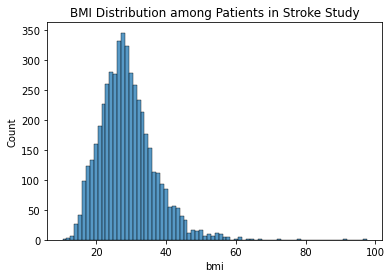

In [716]:
sns.histplot(df, x = "bmi").set_title('BMI Distribution among Patients in Stroke Study')

Text(0.5, 1.0, 'Age Distributino in Stroke Study')

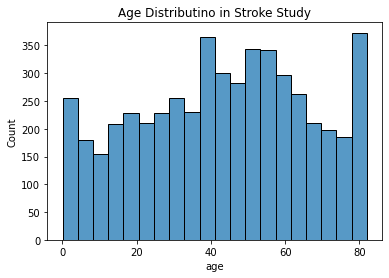

In [717]:
sns.histplot(df, x ='age').set_title('Age Distributino in Stroke Study')

In the distribution of BMI, outliers appear where BMI exceeds 70 kg/sq.m., so we exclude those outliers for estimation of average BMI. 

Text(0.5, 1.0, 'BMI Distribution among Patients in Stroke Study, outliers removed')

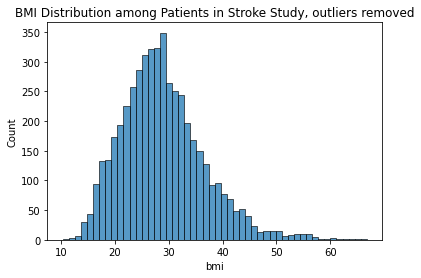

In [718]:
# We select columns of BMI and factors that might be related to it
# We remove rows where BMI exceeds 70 kg/sq.m becquse they are outliers
BMI_factors = df.loc[-(df.bmi > 70),("gender", "age", "Residence_type", "avg_glucose_level", "bmi")].dropna(axis = 0)

sns.histplot(BMI_factors, x = "bmi").set_title('BMI Distribution among Patients in Stroke Study, outliers removed')



According to the American National Institutes of Health (https://www.niddk.nih.gov/health-information/weight-management/adult-overweight-obesity/factors-affecting-weight-health), factors like family history, ethnicity, age, sex, eating habits, where a person lives, and sleep can influence BMI. Of these factors, gender, age, residence_type (related to where a person lives), avg_glucose_level (related to eating habits) were reported in this study. We check visually to see if there is a relationship between these variables and BMI where it is known. 

First, we see no obvious difference in BMI when we group participants by either gender or residence type (urban versus rural); evidently those two factors do not give much information about BMI among participants in this study. 

Text(0.5, 1.0, 'Residence type versus BMI')

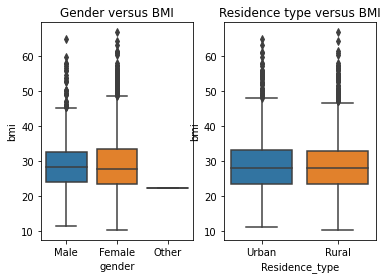

In [719]:
fig, ax =plt.subplots(1,2)
sns.boxplot(x = BMI_factors.gender, y = BMI_factors.bmi, ax = ax[0]).set_title('Gender versus BMI')
sns.boxplot(x = BMI_factors.Residence_type, y = BMI_factors.bmi, ax = ax[1]).set_title('Residence type versus BMI')


####  Relationship between age, average glucose level and BMI among study participants
By plotting age and BMI and average glucose level and BMI, the clouds of points do not appear randomly dispersed. First, BMI  increases with average glucose level, with the trendline showing a positive relationship that appears linear and signficant, with a p-value less than 0.01 (i.e. rejection of null hypothesis that slope of the linear trendline is 0). A relationship appears between age and BMI, but it is not clearly monotonic because the cloud of points does not follow the linear trendline throughout the age range of the study. Instead of being truly linear, BMI increases with age up to 40 years, becomes level, then decreases at 60 years and older.


Text(0.5, 1.0, 'Age vs FMI \n with regression plot')

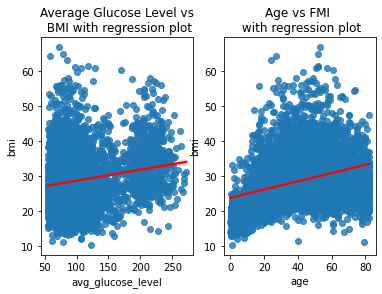

In [801]:
fig, ax =plt.subplots(1,2)

sns.regplot(x=BMI_factors.avg_glucose_level, y=BMI_factors.bmi, 
            fit_reg = True, 
            line_kws={"color" : "red"} ,
            ax = ax[0]
           ).set_title('Average Glucose Level vs\n BMI with regression plot')
sns.regplot(x=BMI_factors.age, y=BMI_factors.bmi, 
            fit_reg = True, 
            line_kws={"color" : "red"} ,
            ax = ax[1]
           ).set_title('Age vs FMI \n with regression plot')


In [802]:
glucose_BMI_LM = stats.linregress(x=BMI_factors.avg_glucose_level, y = BMI_factors.bmi)
age_BMI_LM = stats.linregress(x=BMI_factors.age, y = BMI_factors.bmi)


print("The p-value of the linear model regressing average glucose level to BMI is " ,glucose_BMI_LM.pvalue)
print("The p-value of the linear model regressing age to BMI is ", age_BMI_LM.pvalue)

The p-value of the linear model regressing average glucose level to BMI is  1.3664323788161517e-37
The p-value of the linear model regressing age to BMI is  1.0348373615035425e-136


We create groups by age that capture this nonlinear relationship. 

We also create a lower glucose group (<175 mg/dL) and a high glucose group (175+ mg/dL), where BMI clearly increases with higher glucose group.
 
Finally, we calculate average BMI based on the age and glucose groups created and fill it into our dataframe that includes all observations. 

In [803]:
#create age categories
binsAge = [0, 20, 30,40, 60, np.inf]
namesAge = [ '<20', '20-30', '30-40', '40-60', '60+']
BMI_factors['Age_Group'] = pd.cut(BMI_factors['age'], binsAge, labels = namesAge)

#create glucose levels groups
binsGlucose = [0,175, np.inf]
namesGlucose = [ '<175', '175+']
BMI_factors['Glucose_Group'] = pd.cut(BMI_factors['avg_glucose_level'], binsGlucose, labels = namesGlucose)

Text(0.5, 1.0, 'BMI by Age Group')

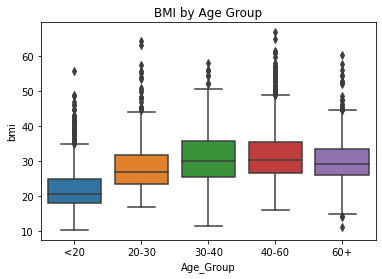

In [804]:
sns.boxplot(x = BMI_factors.Age_Group, y = BMI_factors.bmi).set_title('BMI by Age Group')

Text(0.5, 1.0, 'BMI by Glucose Group')

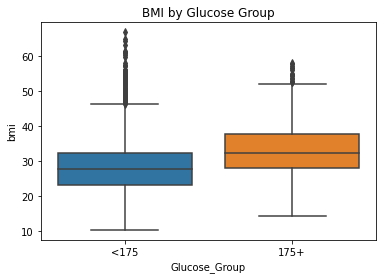

In [805]:
sns.boxplot(x = BMI_factors.Glucose_Group, y = BMI_factors.bmi).set_title('BMI by Glucose Group')

Average BMI among participants grouped by age group and glucose group

In [806]:
BMI_factors.groupby(['Age_Group', 'Glucose_Group']).mean().bmi

Age_Group  Glucose_Group
<20        <175             22.113576
           175+             23.325000
20-30      <175             28.394050
           175+             29.807143
30-40      <175             30.967599
           175+             33.653846
40-60      <175             31.000076
           175+             36.284153
60+        <175             29.129361
           175+             32.209184
Name: bmi, dtype: float64

In [807]:
#create age categories in dataframe containing all observations
binsAge = [0, 20, 30,40, 60, np.inf]
namesAge = [ '<20', '20-30', '30-40', '40-60', '60+']
df['Age_Group'] = pd.cut(df['age'], binsAge, labels = namesAge)

#create glucose levels groups in dataframe containing all observations
binsGlucose = [0,175, np.inf]
namesGlucose = [ '<175', '175+']
df['Glucose_Group'] = pd.cut(df['avg_glucose_level'], binsGlucose, labels = namesGlucose)

In [808]:
# dictionary of BMI based on age, glucose group
average_bmi = BMI_factors.groupby(['Age_Group', 'Glucose_Group']).mean().bmi.to_dict()

#function to evaluate BMI based on input of age group and glucose group
def bmi_guesser(age_glucose_grps):
    age_glucose_grps = tuple(age_glucose_grps)
    bmi = average_bmi[age_glucose_grps]
    return bmi

# loop through age_group and glucose_group keys of our average_bmi dictionary
# locate within our data the observations matching the age/glucose group of each iteration
    # locate the indices where BMI is missing
#fill BMI in our dataframe at those indices

for age,glucose in average_bmi.keys():
    temp_df = df.loc[(df.Age_Group==age) & (df.Glucose_Group == glucose),:]
    missing_values_index = temp_df.loc[temp_df.bmi.isna()].index
    df.loc[missing_values_index,"bmi"] = bmi_guesser([age, glucose])
    
# drop the variables we created for predicting BMI: Age_Group and Glucose_Group

df = df.drop("Age_Group", axis=1)

df = df.drop("Glucose_Group", axis=1)

    
# check if missing values persist
df.isna().sum()


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

There are no more missing values in the data set

#### Exploratory Data Analysis

In [816]:
#Exploratory Analysis and Summary Statistics
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.00000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.93970,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.73531,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.60000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.30000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.90000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


The summary statistics of numeric variables (above) inform us with key facts about the study population. Most importantly, strokes occurred among 4.9% of the population, indicating that this adverse health outcome was a rare event in this study. While we have much less information about individuals who had a stroke than those who did not, the study sample includes over 5000 observations. There were over 250 cases of stroke, and this number could be sufficient to build a model.

With respect to demographic details the average age of participants was 43 years old. Concerning health history, 9,7% had hypertension, 5,4% had heart disease, the average glucose level was 106 mg/dL, and average body mass index (BMI) was 28,9 kg/sq.m. (including observations where BMI was missing and filled in with average by age and glucose level)


Tabulation of the categorical variables below shows similar representation between men (n = 2115) and women (n=2994) and urban (n = 2596) and rural (n = 2513) residents. In one observation, gender was listed as "other." We cannot fully understand the reason given the informatino we have about data collection. Perhaps this individual identified as non-binary or simply declined to share gender information in the study. At any rate, it is a rare observation, so we will drop this individual from the the machine learning model. If future data sets were to have additional individuals with gender as "other", we could consider this third gender category in our prediction model.

The majority (65%) of participants were married. Smoking status, however, is not well understood, because smoking history is unknown among 1544 (30%) participants. This raises an interesting question. If this study set smoking history as unknown, can we consider it missing data? Should our machine learning model estimate smoking history based on demographic factors of study participants? We will resolve this later with depending on the prediction accuracy of our ML model. 

Not all types of workers are represented in this study. Over half of participants worked in the private sector. The percent of them that were self-employed, minors, or government-employed were 16%, 13%, and 13%, respectively. Less than 1% never worked. Consequently, our machine learning model may be more accurate about participants who worked in the private sector, but less accurate for those with other work types. 

In [819]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [820]:
#remove observations where gender is "other"
df = df.drop(df.loc[df.gender == "Other",:].index)
df.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [821]:
df.ever_married.value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [822]:
print("The percentage of work types among study participants is:")
print(df.work_type.value_counts()/len(df)*100)

The percentage of work types among study participants is:
Private          57.232335
Self-employed    16.030534
children         13.446858
Govt_job         12.859659
Never_worked      0.430613
Name: work_type, dtype: float64


In [823]:
df.Residence_type.value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [824]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

#### Correlations among all variables 

Heat maps below demonstrate (again) a positive correlation between age and BMI. There are also high correlations between marriage history (ever_maried) and smoking status, worktype and smoking status, and marriage history and worktype, compared to other variables. The reason is evident in especially in the tables below (see pd.crosstab): the study includes children (13%).  Lifestyle factors such as marriage, smoking, and worktype all are influenced by whether a person is a child or an adult and therefore are not truly independent variables. Therefore, not all three variables should be used in the final model to avoid linear dependence among features (otherwise know as explanatory variables) of the predictive model.

In [825]:
df_native.columns


Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [826]:
df_native.columns[[0,2,3,4,5,6,9]]


Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status'],
      dtype='object')

When we cross-tabulate stroke and categorical variables, we see that hypertension, heart disease, ever_married, and smoking are all correlated with stroke.

In [827]:

for i in df_native.columns[[0,2,3,4,5,6,9]]:
   
    #print(df_native.loc[:,i].value_counts()/len(df_native))
    table = pd.crosstab( df_native.loc[:,i],[ df_native.stroke], 
            rownames = [i], 
            colnames= [ 'stroke'],
            normalize= 'columns')
    print(table,'\n \n')


stroke         0         1
gender                    
Female  0.586916  0.566265
Male    0.412878  0.433735
Other   0.000206  0.000000 
 

stroke               0        1
hypertension                   
0             0.911129  0.73494
1             0.088871  0.26506 
 

stroke               0         1
heart_disease                   
0              0.95289  0.811245
1              0.04711  0.188755 
 

stroke               0         1
ever_married                    
No            0.355482  0.116466
Yes           0.644518  0.883534 
 

stroke                0         1
work_type                        
Govt_job       0.128369  0.132530
Never_worked   0.004526  0.000000
Private        0.571076  0.598394
Self-employed  0.155112  0.261044
children       0.140918  0.008032 
 

stroke                 0         1
Residence_type                    
Rural           0.493726  0.457831
Urban           0.506274  0.542169 
 

stroke                  0         1
smoking_status                     

Text(0.5, 1.0, 'Stroke status by Smoking Status')

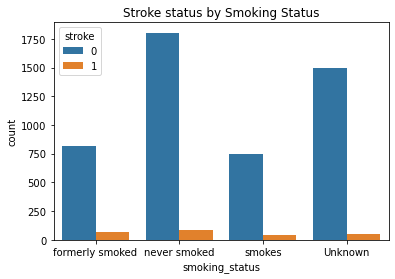

In [828]:
sns.countplot(data = df_native, x= 'smoking_status', hue = 'stroke').set_title('Stroke status by Smoking Status')


Text(0.5, 1.0, 'Stroke occurence among urban versus rural study participants')

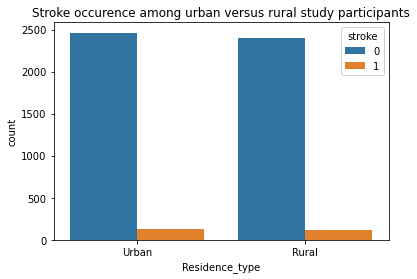

In [829]:
sns.countplot(data = df_native, x= 'Residence_type', hue = 'stroke').set_title('Stroke occurence among urban versus rural study participants')


Text(0.5, 1.0, 'Work type among study participants and incidence of stroke')

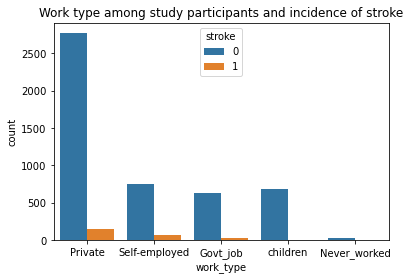

In [830]:
sns.countplot(data = df_native, x= 'work_type', hue = 'stroke').set_title('Work type among study participants and incidence of stroke')


Text(0.5, 1.0, 'Gender count')

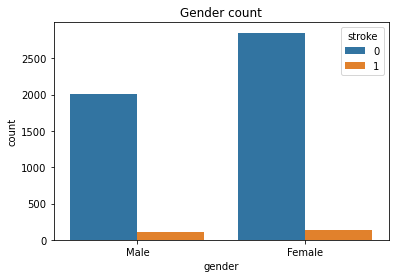

In [831]:
sns.countplot(data = df, x= 'gender', hue = 'stroke').set_title('Gender count')

Text(0.5, 1.0, 'Marriage history among study participants and stroke incidence')

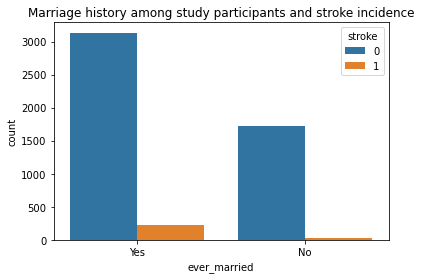

In [832]:
sns.countplot(data = df, x= 'ever_married', hue = 'stroke').set_title('Marriage history among study participants and stroke incidence')


Text(0.5, 1.0, 'Heart Disease and Stroke')

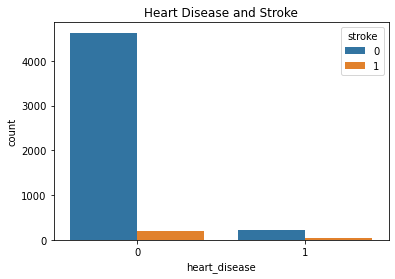

In [833]:
sns.countplot(data = df, x= 'heart_disease', hue = 'stroke').set_title('Heart Disease and Stroke')


Text(0.5, 1.0, 'Hypertension')

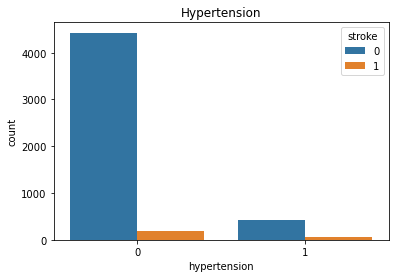

In [834]:
sns.countplot(data = df, x= 'hypertension', hue = 'stroke').set_title('Hypertension')


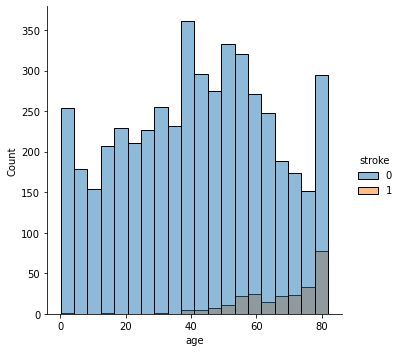

In [866]:

sns.displot(data=df, x= 'age', hue = 'stroke')


In [ ]:
sns.histplot(data=df, x= 'avg_glucose_level', hue = 'stroke', binwidth= 10).set_title('Average Glucose Level')


In [836]:
sns.histplot(data=df, x= 'bmi', hue = 'stroke', 'BMI Distribution and Stroke')

SyntaxError: positional argument follows keyword argument (1528963571.py, line 1)

We also see that age and average glucose level are associated with stroke as well in our study population. 

Text(0.5, 1.0, 'Age vs Average Glucose Level')

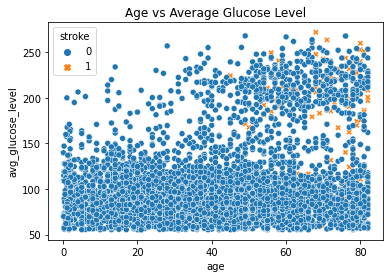

In [837]:
sns.scatterplot(data = df, x = 'age', y = 'avg_glucose_level', 
                hue = 'stroke', 
                style = 'stroke').set_title('Age vs Average Glucose Level')



In [838]:
#correlation among numeric variables
plt.figure(figsize=(10,10))
num_corr = df.corr()
sns.heatmap(num_corr)..set_title('Correlation among variables #1')

SyntaxError: invalid syntax (685333995.py, line 4)

Text(0.5, 1.0, 'Correlation among variables #2')

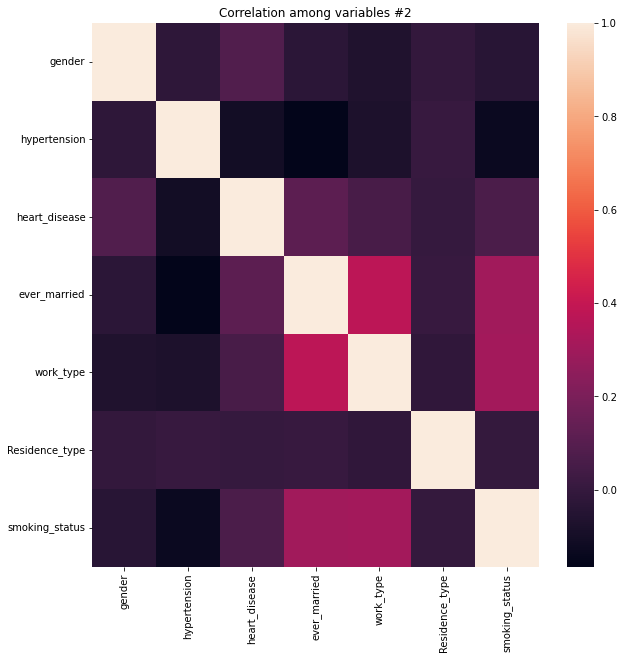

In [839]:
#correlation among categorical variables
plt.figure(figsize=(10,10))
correlation = df.iloc[:,[0,2,3,4,5,6,9]].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(data = correlation).set_title('Correlation among variables #2')

In [840]:
#cross tabulate: 
# 1.marriage status, smoking status
# 2.marriage status , work type
# 3. work type, smoking status
pd.crosstab(df.smoking_status,[df.work_type], 
            rownames = ['smoking status'], 
            colnames= ["work type"],
            normalize= 'columns'
           )

work type,Govt_job,Never_worked,Private,Self-employed,children
smoking status,,,,,
Unknown,0.185693,0.363636,0.218878,0.190476,0.899563
formerly smoked,0.202435,0.000000,0.181259,0.253968,0.018923
never smoked,0.429224,0.636364,0.414159,0.404151,0.078603
smokes,0.182648,0.000000,0.185705,0.151404,0.002911


In [841]:
pd.crosstab(df.smoking_status,[ df.ever_married], 
            rownames = ['smoking status'], 
            colnames= [ "Marriage history"],
           normalize= 'columns')

Marriage history,No,Yes
smoking status,,
Unknown,0.513098,0.191769
formerly smoked,0.083144,0.220101
never smoked,0.301822,0.406203
smokes,0.101936,0.181927


In [842]:
pd.crosstab(df.work_type,[df.ever_married], 
            rownames = ['Work type'], 
            colnames= ["Marriage history"],
            normalize= 'columns'
           )

Marriage history,No,Yes
Work type,,
Govt_job,0.066629,0.161050
Never_worked,0.012528,0.000000
Private,0.466970,0.627498
Self-employed,0.062642,0.211452
children,0.391230,0.000000


### Feature Engineering and Selection

After resolving missing data and removing rare observations, we proceed with feature engineering. Building the ML model requires numeric values only, so the purpose here is to:
- Convert categorical variables that either are binary (e.g., gender, ever_married, Residence_type) have a hierarchical quality to ordinal variables (not applicable in this data set)
- Convert categorical variables that have no hierarchy (e.g., work_type, smoking_status) to boolean dummy variables using the one-hot encoding method
- Remove any variables that appear superfluous and unlikely to include meaningful information in prediction of stroke


In [843]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,32.209184,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [844]:
#transform categorical variables to boolean
#transform categorical variables to boolean
df.loc[:,'gender'] = pd.get_dummies(df.gender, drop_first=True).values


In [845]:
df.loc[:,'ever_married'] = pd.get_dummies(df.ever_married, drop_first=True).values
df.loc[:,'Residence_type'] = pd.get_dummies(df.Residence_type, drop_first=True).values

In [846]:
#encode one-hot variables/dummy variables
#remove one of the dummy variables so that the set of variables are not linearly dependent (drop_first = True)
#work_type
df = pd.concat([df, pd.get_dummies(df.work_type, drop_first=True)], axis = 1).drop(columns="work_type")



In [847]:
#encode one-hot variables/dummy variables
#remove one of the dummy variables so that the set of variables are not linearly dependent (drop_first = True)
#smoking status

df = pd.concat([df, pd.get_dummies(df.smoking_status, drop_first = True)], axis = 1).drop(columns="smoking_status")



In [848]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes
id,,,,,,,,,,,,,,,,
9046,1,67.0,0,1,1,1,228.69,36.600000,1,0,1,0,0,1,0,0
51676,0,61.0,0,0,1,0,202.21,32.209184,1,0,0,1,0,0,1,0
31112,1,80.0,0,1,1,0,105.92,32.500000,1,0,1,0,0,0,1,0
60182,0,49.0,0,0,1,1,171.23,34.400000,1,0,1,0,0,0,0,1
1665,0,79.0,1,0,1,0,174.12,24.000000,1,0,0,1,0,0,1,0


All categorical variables have been converted to dummy variables. None of the variables seem superfluous; however, we know that smoking, ever_married, and work_type are not fully indpendent of each other, as discussed above. For model training, we'll test: 
1) A full model with all features

2) A model including smoking, but not ever_married and work_type

3) A model including ever_married, but not smoking and work_type

4) A model including work_type, but not ever_married and smoking


In [849]:
#set x and y columns
#df_y = df.loc[:,'stroke']
#df_x =df.drop('stroke', axis = 1)


In [850]:
#full features  set 1
df_1 = df


#smoking, but not ever_married and work_type

#NOTE: WEIGHTED SAMPLING
df_2 = df_sample1.drop(['ever_married',
                  'Never_worked', 'Private', 'Self-employed', 'children'], 
                 axis = 1)

#ever_married, but not smoking and work_type
df_3 = df_sample1.drop(['formerly smoked', 'never smoked', 'smokes',
                  'Never_worked', 'Private', 'Self-employed', 'children'], 
                 axis = 1)

#work_type, but not ever_married and smoking
df_4 = df_sample1.drop(['ever_married',
                  'formerly smoked', 'never smoked', 'smokes'], axis = 1)

Full features set 1

In [851]:
df_4.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,Never_worked,Private,Self-employed,children
id,,,,,,,,,,,,
9046,1,67.0,0,1,1,228.69,36.600000,1,0,1,0,0
51676,0,61.0,0,0,0,202.21,32.209184,1,0,0,1,0
31112,1,80.0,0,1,0,105.92,32.500000,1,0,1,0,0
60182,0,49.0,0,0,1,171.23,34.400000,1,0,1,0,0
1665,0,79.0,1,0,0,174.12,24.000000,1,0,0,1,0


In [852]:
df_1.columns


Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'Never_worked',
       'Private', 'Self-employed', 'children', 'formerly smoked',
       'never smoked', 'smokes'],
      dtype='object')

Features set 2

In [853]:
df_2.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'formerly smoked', 'never smoked',
       'smokes'],
      dtype='object')

Features set 3

In [854]:
df_3.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke'],
      dtype='object')

Features set 4

In [855]:
df_4.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'Never_worked', 'Private',
       'Self-employed', 'children'],
      dtype='object')

In [856]:
stroke = df_1.loc[(df_1.stroke == 1),]
no_stroke =     df_1.loc[(df_1.stroke == 0),].sample(n=250)
df_sample1 = pd.concat([stroke, no_stroke])


### Model Training

Here we will build 4 different models with our four sets of features: 1) linear regression, 2) decision tree, 3) random forest, 4) multi-layer perceptron (neural network).

#### Key findings

The logistic regression model was unable to predict occurrence of stroke in the complete data set. When the data were resampled, such that stroke patient data were completely sampled (n=249) and non-stroke patient data were randomly undersampled(n=250), prediction accuracy improved. 

In [857]:
'''
Our model builder function will accomplish the following:
- perform train, test split
- get values of columns for training data
- get values of columns for test data
- fit logistic regression to predict stroke
- fit a decision tree classifier to predict stroke
- fit a random forest to predict stroke
- for each model, produce a classification report
'''

# import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


def Model_builder (df_model):
    #split data for training and testing
    df_train, df_test = train_test_split(df_model,
                                         test_size = 0.2, random_state=0)
    
        #get values for training
    X_train = df_train.loc[ : , df_train.columns].drop('stroke', axis = 1).values
    y_train = df_train.stroke.values
    
    #get values for testing    
    X_test = df_test.loc[ : , df_test.columns].drop('stroke', axis = 1).values
    y_test = df_test.stroke.values
    
    
    #LOGISTIC REGRESSION MODEL
    #initialize
    lr_model = LogisticRegression(random_state=0,max_iter=1000)
    
    #train model
    lr_model.fit(X = X_train, y= y_train)
    
    #predict using test data and our logistic regression model
    y_test_predicted = lr_model.predict(X_test)
    
    #regression model accuracy report
    report_lr =classification_report(y_true=y_test, 
                                     y_pred=y_test_predicted)
    
    cf = pd.DataFrame(
    columns=["y_pred_0","y_pred_1"],index=["y_test_0","y_test_1"])    
    
    cf.loc[:,:] = confusion_matrix(
        y_true= y_test,
        y_pred = y_test_predicted) 

    report =classification_report(y_true=y_test, y_pred=y_test_predicted)
    print(cf)
    print('The classification report for the logistic regression model is:\n\n',report)
    
    
    #DECISION TREE MODEL
    #initialize
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X=X_train,y=y_train)
    y_test_predicted_dt = dt_model.predict(X_test)
    report_dt = classification_report(y_pred=y_test_predicted_dt,y_true=y_test)
    print('The classification report for the Decision Tree Model is:\n\n', report_dt)
    

    #RANDOM FOREST MODEL
    #Initialize
    rf_model = RandomForestClassifier()
    rf_model.fit(X=X_train,y=y_train)
    y_test_predicted_rf = rf_model.predict(X_test)
    report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=y_test)
    print('The classification report for the Random Forest Model is:\n\n', report_rf)
    
    #MULTI-LAYER PERCEPTRON CLASSIFIER
    #initialize
    nn_model = MLPClassifier(hidden_layer_sizes=(20, 10),max_iter=1000)
    nn_model.fit(X=X_train,y=y_train)
    y_test_predicted_nn = nn_model.predict(X_test)
    report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=y_test)
    print('The classification report for the MLP model is:\n\n',report_nn)

In [858]:
#model based on complete data set, all columns
Model_builder(df_1)

         y_pred_0 y_pred_1
y_test_0      968        0
y_test_1       53        1
The classification report for the logistic regression model is:

               precision    recall  f1-score   support

           0       0.95      1.00      0.97       968
           1       1.00      0.02      0.04        54

    accuracy                           0.95      1022
   macro avg       0.97      0.51      0.50      1022
weighted avg       0.95      0.95      0.92      1022

The classification report for the Decision Tree Model is:

               precision    recall  f1-score   support

           0       0.95      0.96      0.95       968
           1       0.13      0.11      0.12        54

    accuracy                           0.91      1022
   macro avg       0.54      0.53      0.54      1022
weighted avg       0.91      0.91      0.91      1022

The classification report for the Random Forest Model is:

               precision    recall  f1-score   support

           0       0.95 

/Users/jeremyschwartzbord/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeremyschwartzbord/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeremyschwartzbord/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [859]:
#model based on undersampling of no-stroke patients, all columns
Model_builder(df_sample1)

         y_pred_0 y_pred_1
y_test_0       37       14
y_test_1        9       40
The classification report for the logistic regression model is:

               precision    recall  f1-score   support

           0       0.80      0.73      0.76        51
           1       0.74      0.82      0.78        49

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

The classification report for the Decision Tree Model is:

               precision    recall  f1-score   support

           0       0.70      0.69      0.69        51
           1       0.68      0.69      0.69        49

    accuracy                           0.69       100
   macro avg       0.69      0.69      0.69       100
weighted avg       0.69      0.69      0.69       100

The classification report for the Random Forest Model is:

               precision    recall  f1-score   support

           0       0.77 

In [860]:
#model based on undersampling of no-stroke patients
#ever_married, worktype dropped

Model_builder(df_2)

         y_pred_0 y_pred_1
y_test_0       39       12
y_test_1       12       37
The classification report for the logistic regression model is:

               precision    recall  f1-score   support

           0       0.76      0.76      0.76        51
           1       0.76      0.76      0.76        49

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100

The classification report for the Decision Tree Model is:

               precision    recall  f1-score   support

           0       0.72      0.71      0.71        51
           1       0.70      0.71      0.71        49

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100

The classification report for the Random Forest Model is:

               precision    recall  f1-score   support

           0       0.77 

In [861]:
#model based on undersampling of no-stroke patients
#smoking, worktype dropped
Model_builder(df_3)

         y_pred_0 y_pred_1
y_test_0       37       14
y_test_1       11       38
The classification report for the logistic regression model is:

               precision    recall  f1-score   support

           0       0.77      0.73      0.75        51
           1       0.73      0.78      0.75        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100

The classification report for the Decision Tree Model is:

               precision    recall  f1-score   support

           0       0.68      0.78      0.73        51
           1       0.73      0.61      0.67        49

    accuracy                           0.70       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.70      0.70      0.70       100

The classification report for the Random Forest Model is:

               precision    recall  f1-score   support

           0       0.78 

In [862]:
#model based on undersampling of no-stroke patients
#smoking, ever_married dropped

Model_builder(df_4)

         y_pred_0 y_pred_1
y_test_0       38       13
y_test_1       11       38
The classification report for the logistic regression model is:

               precision    recall  f1-score   support

           0       0.78      0.75      0.76        51
           1       0.75      0.78      0.76        49

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100

The classification report for the Decision Tree Model is:

               precision    recall  f1-score   support

           0       0.69      0.67      0.68        51
           1       0.67      0.69      0.68        49

    accuracy                           0.68       100
   macro avg       0.68      0.68      0.68       100
weighted avg       0.68      0.68      0.68       100

The classification report for the Random Forest Model is:

               precision    recall  f1-score   support

           0       0.73 

When building models, we learned that there was an impact of representativeness of stroke victims on model performance with the test data set. 

Regression Model
With the full data set, model precision was high (>=0.95) for prediction of stroke and no-stroke patients, recall was high for no-stroke patients, but recall was poor (0.02) for stroke victims. When no-stroke patients were undersampled, however, recall for stroke patients improved (0.78), albeit at the expense of recall for no-stroke (0.73) and prevision (0.77 and 0.73 for no-stroke and stroke patients, respectively.) 

We also tested if variable selection, specifically removal of somewhat correlated variables like marriage, smoking, and work-type, could improve classification accuracy. There was a marginal improvement in recall accuracy by 1% when smoking was including in the model and mariage, worktype were not. This improvement however is marginal. 

In summary, all four prediction models demonstrated an average F1 accuracy between 0.68 and 0.78; the decision tree model should not be selected because it had lower accuracy than all other model types. The best model performance (0.78) was observed with the random forest when ever_married and work_type were excluded. The most consistent, high performing model was the logistic regression with an accuracy of 0.75 to 0.77. Model performance changed little based on the variable selection group in this analysis, so we cannot reject the null hypothesis concerning variable selection. 

In future study, we can test if data augmentation improves our model. For this we could use the SMOTE algorithm as described in https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/. This technique has been featured as well other data scientists developing models with this same data set, described on Kaggle.com:
https://www.kaggle.com/code/tanmay111999/stroke-prediction-effect-of-data-leakage-smote
https://www.kaggle.com/code/siddheshera/stroke-eda-smote-9-models-90-accuracy

We could also further tune the neural network models, optimize the random forest model, and do additional variable selection with the logistic regression. 